Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from yahoo_fin.stock_info import get_data

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'DOGE'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = get_data(f'{crypto_currency}-{against_currency}', start, end, index_as_date = True, interval = '1d')
base_df

,open,high,low,close,adjclose,volume,ticker
2014-09-16,0.000293,0.000299,0.000260,0.000268,0.000268,1.463600e+06,DOGE-USD
2014-09-17,0.000268,0.000325,0.000267,0.000298,0.000298,2.215910e+06,DOGE-USD
2014-09-18,0.000298,0.000307,0.000275,0.000277,0.000277,8.835630e+05,DOGE-USD
2014-09-19,0.000276,0.000310,0.000267,0.000292,0.000292,9.930040e+05,DOGE-USD
2014-09-20,0.000293,0.000299,0.000284,0.000288,0.000288,5.391400e+05,DOGE-USD
...,...,...,...,...,...,...,...
2021-07-23,0.194823,0.204369,0.191344,0.197319,0.197319,1.695868e+09,DOGE-USD
2021-07-24,0.197173,0.200451,0.191697,0.197864,0.197864,1.256117e+09,DOGE-USD
2021-07-25,0.198030,0.232767,0.197063,0.204419,0.204419,4.863226e+09,DOGE-USD
2021-07-26,0.203836,0.209293,0.195350,0.205899,0.205899,2.229903e+09,DOGE-USD


In [3]:
base_df['spread'] = base_df.high - base_df.low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2507 entries, 2014-09-16 to 2021-07-27
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      2503 non-null   float64
 1   high      2503 non-null   float64
 2   low       2503 non-null   float64
 3   close     2503 non-null   float64
 4   adjclose  2503 non-null   float64
 5   volume    2503 non-null   float64
 6   ticker    2507 non-null   object 
 7   spread    2503 non-null   float64
dtypes: float64(7), object(1)
memory usage: 176.3+ KB


## Plot the closing value of Dogecoin over time

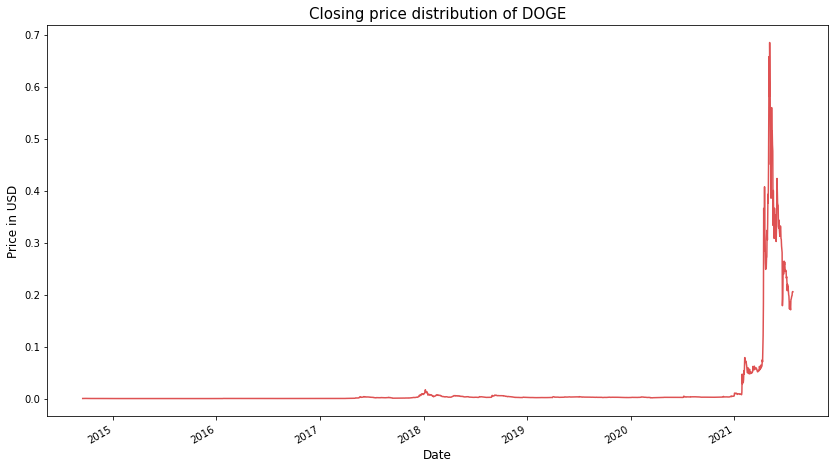

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of DOGE", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Daily price spread of DOGE')

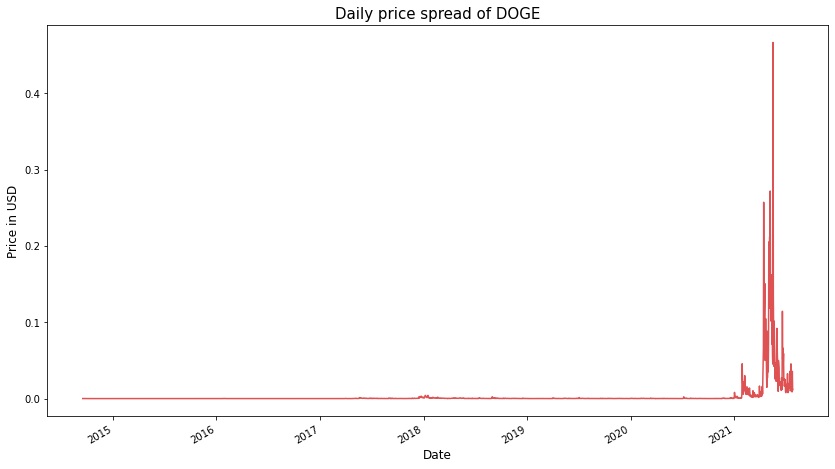

In [5]:
fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.spread.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Daily price spread of DOGE", fontsize=15)

## Candlestick chart

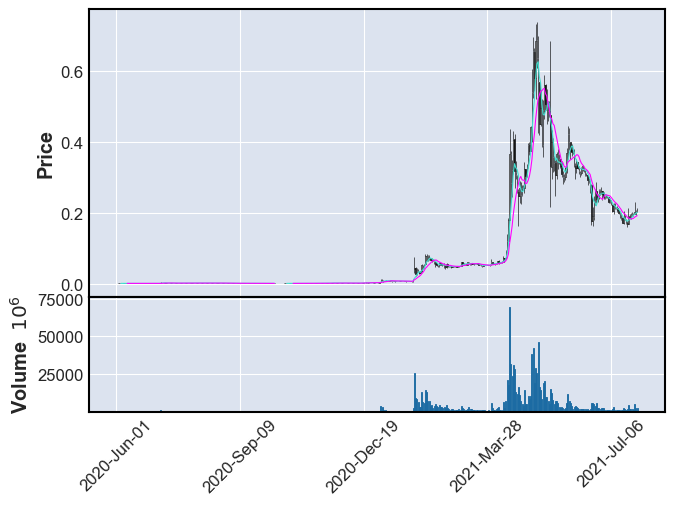

In [6]:
import matplotlib.ticker as mticker
import mplfinance as mpf

temp_base_df = base_df.copy(deep=False)

temp_base_df = temp_base_df.drop(['spread'], axis=1)
mpf.plot(temp_base_df.loc['2020-6-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
price_predict_df = base_df['close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
#price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
0,2014-09-16,0.000268
1,2014-09-17,0.000298
2,2014-09-18,0.000277
3,2014-09-19,0.000292
4,2014-09-20,0.000288
...,...,...
2502,2021-07-23,0.197319
2503,2021-07-24,0.197864
2504,2021-07-25,0.204419
2505,2021-07-26,0.205899


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2525,2021-08-22,0.226854,0.180518,0.272573
2526,2021-08-23,0.226534,0.179495,0.270754
2527,2021-08-24,0.226094,0.183372,0.268847
2528,2021-08-25,0.225777,0.181512,0.272012
2529,2021-08-26,0.225992,0.182067,0.272201


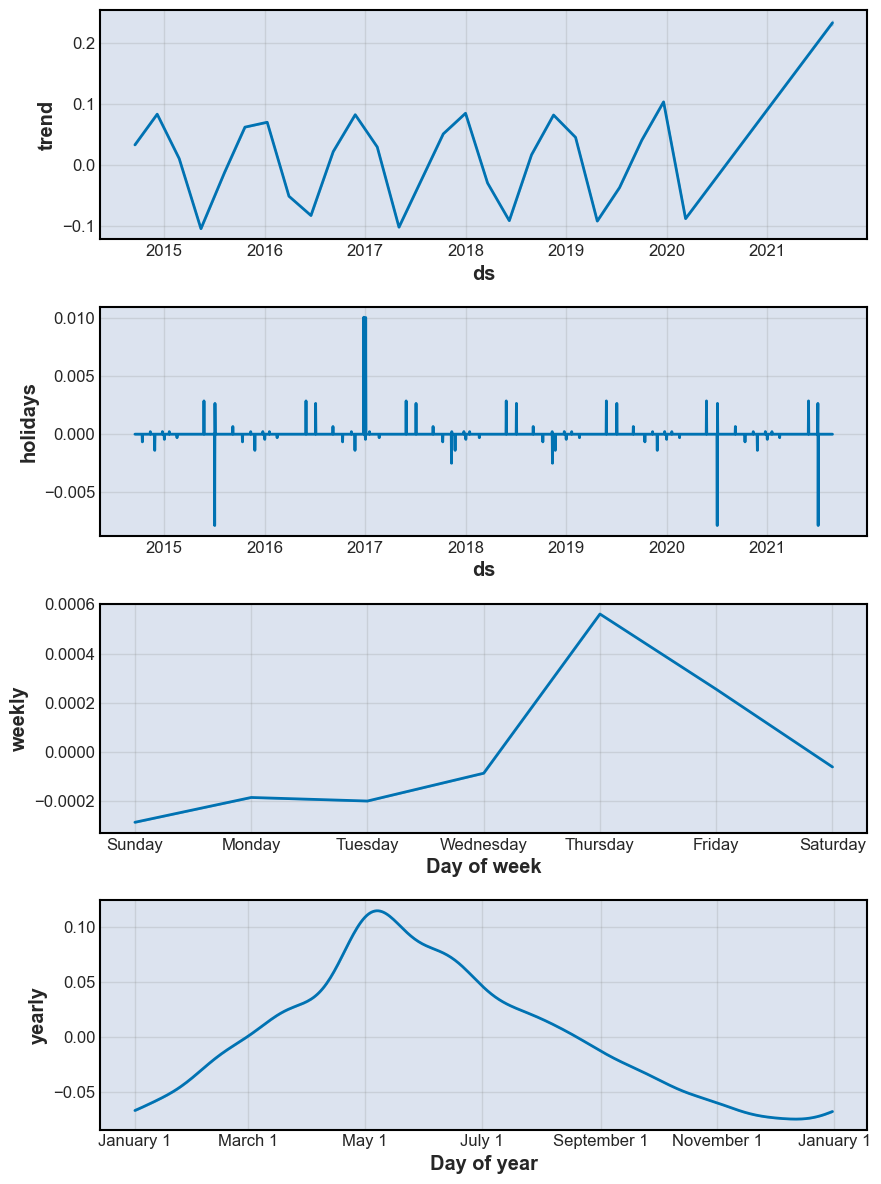

In [9]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
#m.add_country_holidays(country_name='CN')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=30)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

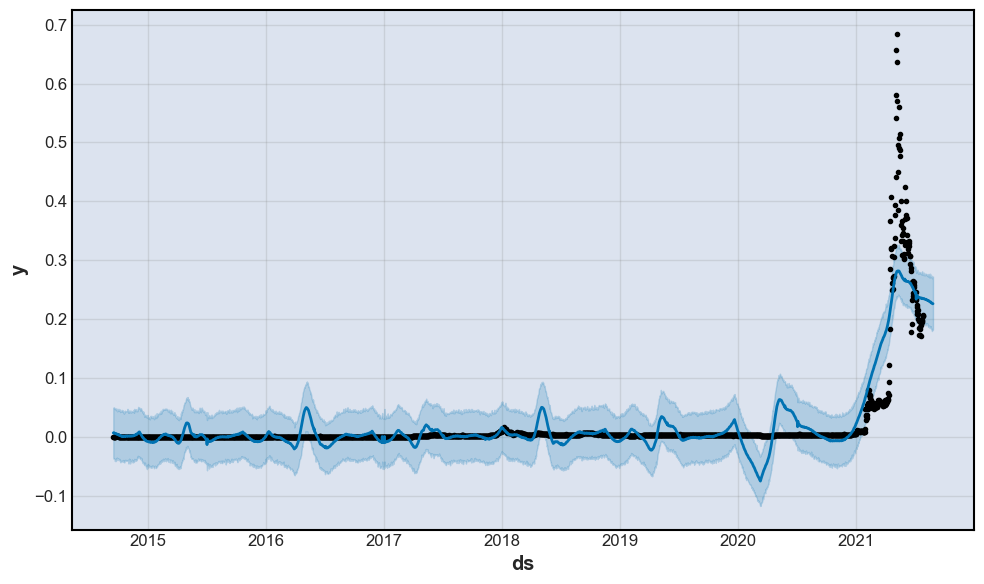

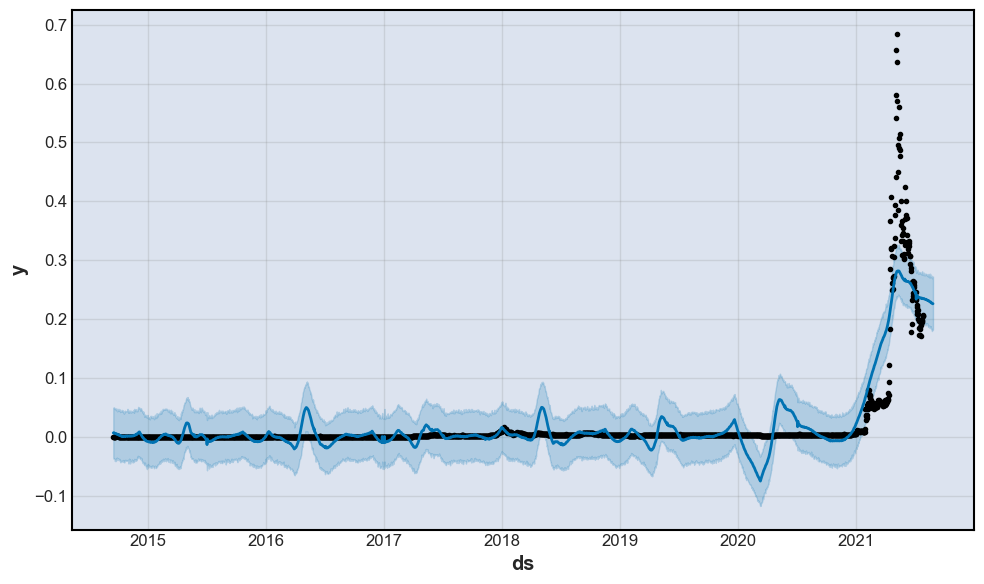

In [10]:
m.plot(forecast)